In [1]:
# GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM
D = 8 # Amount of documents
V = 12 # Size of the vocabulary

# (Approximate) Maximum allowed amount of same word repetition in a document (it may be lower in practise due to the data generation strategy)
# To get the actual maximum amount, call Simulator.get_M
M = 10 

k = 5 # Amount of topics
gamma = 0.05

In [2]:
# # GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM
# D = 100 # Amount of documents
# V = 20 # Size of the vocabulary

# # (Approximate) Maximum allowed amount of same word repetition in a document (it may be lower in practise due to the data generation strategy)
# # To get the actual maximum amount, call Simulator.get_M
# M = 10 

# k = 10 # Amount of topics
# gamma = 0.05

## IMPORTANT: Please use static random seeds in **EVERY** cell where you use a random function, so that the result does **NOT** change at every run.

# 1. ARTIFICIAL DATA

### Task:

You must implement an algorithm that generates an artificial *corpus*, and return also a graph G and a correlation matrix Sigma.

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import bernoulli
#!pip install sklearn
from sklearn.datasets import make_sparse_spd_matrix

In [4]:
# Transformation functions (deterministic)

def update_Theta(Theta, H):
    for d in range(D):
        Theta[d] = np.exp(H[d]) / np.sum(np.exp(H[d]), axis=0)
    print('Success: Theta transformed from H')
    return Theta

def update_E(E, Z):
    k = E.shape[1]
    for topic in range(k):
        E[:, topic] = np.sum(Z == topic, axis=2).sum(axis=1)
    print('Success: E transformed from Z')
    return E

def update_C(C, Z):
    k = C.shape[0]
    for topic in range(k):
        C[topic, :] = np.sum(Z == topic, axis=2).sum(axis=0)
    print('Success: C transformed from Z')
    return C

def update_B(B, C):
    # Note this is the transformation from C
    for topic in range(0, len(B)):
        B[topic] = C[topic] / sum(C[topic])
    print('Success: B transformed from C')
    return B

def update_Sigma(K):
    Sigma = np.linalg.inv(K)
    print('Success: Sigma transformed from K')
    return Sigma

In [5]:
# Random / Generating functions

def build_topic_distribution(seed):
    np.random.seed(seed)
    distribution = np.random.random(V)
    return distribution / distribution.sum()

def sample_B(seed):
    # B is the matrix whose rows are the distribution of topic i over the vocabulary
    # Each row means : for each topic i we have the probability of word i to occur
    # TODO: Change with Dirichlet prior -> See line to change
    b = np.empty((k,V))
    np.random.seed(seed)
    for i in range(k):
        b[i,:] = build_topic_distribution(seed)  # TODO: Change
    return b

def sample_G(k, gamma, seed):  # Won't update Sigma automatically anymore
    # Bernoulli for G
    # generate a random adjacency matrix
    np.random.seed(seed)
    matrix = np.array([[int(bernoulli.rvs(p=gamma, size=1)) for i in range(k)] for j in range(k)])
    for i in range(k):
        matrix[i][i] = 0
    for i in range(k):
        for j in range(k):
            matrix[j][i] = matrix[i][j]
    return matrix

def sample_K(k, seed):  # Won't update Sigma automatically anymore
    # I can build K for using make_sparse_spd_matrix from sklearn.datasets for example
    np.random.seed(seed)
    K = make_sparse_spd_matrix(k, alpha=0.95, norm_diag=False, smallest_coef=0.1, largest_coef=0.9, random_state=None)
    return K

def sample_H(Sigma, D, k, seed):  # Won't update Theta automatically anymore
    # Multivariate Normal
    mu = np.zeros(k)
    np.random.seed(seed)
    H = np.random.multivariate_normal(mu, Sigma, D)
    return H

def sample_Z_from_W(W, k, seed):
    D, V = W.shape
    M = int(W.max())
    Z = -np.ones((D, V, M))
    np.random.seed(seed)
    for d in range(D):
        for w in range(V): 
            occurrences = W[d, w]
            Z[d, w, 0:occurrences] = np.random.randint(0, k, size=occurrences)    
    return Z

In [6]:
# Main Simulator Class
class Simulator:
    
    # Remember we will have indexes starting from 0 so all max are -=1
    
    def __init__(self, D, V, M, k, gamma, seed):
        # Create zero matrices for all possible matrices
        self.W = np.zeros((D, V))  # matrix of D×V where Wdn is counter of appearances of the word n in document d
        self.B = np.zeros((k, V))  # matrix of kxV where Bz is the parameter vector of the distribution for the z-th topic
        self.C = np.zeros((k, V))  # matrix of kxV where Cz is the count vec of sampled topics over each word for all docs
        self.E = np.zeros((D, k))  # matrix of Dxk where Ed is the count vec of sampled drawings for topic z over all words for each doc
        self.H = np.zeros((D, k))  # H_d is eta_d
        self.Theta = np.zeros((D, k))  # This is just a transformation of H
        self.G = np.zeros((k, k))  # Adjacency Matrix (Check also python package "networkx" for graph objects!)
        self.K = np.zeros((k, k))  # Precision matrix of G
        self.Sigma = np.zeros((k, k))  # Inverse of K
        self.Z = -np.ones((D, V, M))  # Topic assignments for each words of each document
        self.D = D
        self.V = V
        self.M = M
        self.k = k
        self.gamma = gamma
        self.seed = seed  # Random seed
        
    def get_M(self):
        # Ref: https://numpy.org/doc/stable/reference/generated/numpy.matrix.max.html
        return int(self.W.max())

    # Generations
    def generate_WZ(self):
        if M == 0:
            raise Exception('Error: M value is 0')
        elif np.sum(self.Theta, axis=1).sum(axis=0) == 0:
            raise Exception('Error: Theta matrix 0')
        elif np.sum(self.B, axis=1).sum(axis=0) == 0:
            raise Exception('Error: B matrix 0')
        
        np.random.seed(self.seed)
        # Ref https://numpy.org/doc/stable/reference/random/generated/numpy.random.multinomial.html
        # Multinomial drawing for Z and then W
        for d in range(self.D):
            
            # Maximum number of word drawings in the document            
            N_d = np.random.randint(1, int(self.M * self.V * 0.7))  # Hard-coding 70% thinning factor
            for n in range(N_d):
                
                # Multinomial drawing from Theta, because it has to be normalized
                # This will give a canonical vector over k
                mult = np.random.multinomial(1, self.Theta[d], size=1)  # This is a vector of 0's with a single 1
                z = np.argmax(mult)  # This is the index of the 1 (Topic index)
                
                # Multinomial drawing from Beta
                # This will give a canonical vector over V
                mult = np.random.multinomial(1, self.B[z], size=1)  # This is a vector of 0's with a single 1
                w = np.argmax(mult)  # This is the index of the 1 (Word index)
                
                empty_cell_indexes = np.nonzero(self.Z[d, w] == -1)[0]  # Check if there are still possible unassigned occurrences for this word
                if empty_cell_indexes.size != 0:  # At least one entry is not assigned
                    first_empty_index = empty_cell_indexes[0]
                    self.Z[d, w, first_empty_index] = z  # Assinging word to topic
                    self.W[d, w] += 1  # Increasing word counter
        
        print('Success: W and Z generated')

        # TODO: I have replaced this function in order to have the exact M
#     # Generations
#     def generate_WZ(self):
#         if M == 0:
#             raise Exception('Error: M value is 0')
#         elif np.sum(self.Theta, axis=1).sum(axis=0) == 0:
#             raise Exception('Error: Theta matrix 0')
#         elif np.sum(self.B, axis=1).sum(axis=0) == 0:
#             raise Exception('Error: B matrix 0')
        
#         Z = [[[] for k in range(self.V)] for j in range(self.D)]  # Unknown amount of repetitions
#         np.random.seed(self.seed)
#         # Ref https://numpy.org/doc/stable/reference/random/generated/numpy.random.multinomial.html
#         # Multinomial drawing for Z and then W
#         for d in range(self.D):
#             # Maximum of words in the document: Lower int of 70% of M * V
#             N_d = np.random.randint(0, (5 * self.M * self.V) // 10)
#             for n in range(N_d):
                
#                 # Multinomial drawing from Theta, because it has to be normalized
#                 # This will give a canonical vector over k
#                 mult = np.random.multinomial(1, self.Theta[d], size=1)  # This is a vector of 0's with a single 1
#                 z = np.argmax(mult)  # This is the index of the 1 (Topic index)
                
#                 # Multinomial drawing from Beta
#                 # This will give a canonical vector over V
#                 mult = np.random.multinomial(1, self.B[z], size=1)  # This is a vector of 0's with a single 1
#                 w = np.argmax(mult)  # This is the index of the 1 (Word index)
                
#                 Z[d][w].append(z)
#                 self.W[d,w] += 1
        
#         print('Success: W generated')
#         self.Z = - np.ones((self.D, self.V, self.get_M()))
#         for d in range(self.D):
#             for n in range(self.V):
#                 for i in range(len(Z[d][n])):  # Only take existing topics
#                     self.Z[d][n][i] = Z[d][n][i]  # Replace
#         print('Success: Z generated')
    
    # Transformations
    def update_Theta(self):
        self.Theta = update_Theta(self.Theta, self.H)
    
    def update_E(self):
        self.E = update_E(self.E, self.Z)
    
    def update_C(self):
        self.C = update_C(self.C, self.Z)
    
    def update_Sigma(self):
        self.Sigma = update_Sigma(self.K)
    
    # Initializing with real data
    # def save_W()
    
    # Priors
    def sample_B(self):
        self.B = sample_B(self.seed)
        
    def sample_GK(self):  # Here we can update Sigma automatically
        self.G = sample_G(self.k, self.gamma, self.seed)
        self.K = sample_K(self.k, self.seed)
        self.update_Sigma()
    
    def sample_H(self):  # Here we can update Theta automatically
        self.H = sample_H(self.Sigma, self.D, self.k, self.seed)
        self.update_Theta()
    
    def generate_all_data(self):
        # TODO: This should run all relevant methods one after the other in order to fully populate all data matrixes
        self.sample_B()  # Will get B
        self.sample_GK()  # Will get G, K, Sigma
        self.sample_H()  # Will get H, Theta from Sigma
        self.generate_WZ()  # Will get W, Z from Theta, B
        self.update_E()  # Will get E from Z
        self.update_C()  # Will get C from Z
        pass

## 1.1 Simulator Tests

In [7]:
test0 = Simulator(D, V, M, k, gamma, seed=1996)
test0.sample_GK()  # Will get G, K, Sigma
test0.sample_H()  # Will get H, Theta from Sigma
test0.sample_B()  # Will get B
test0.generate_WZ()
test0.update_E()

Success: Sigma transformed from K
Success: Theta transformed from H
Success: W and Z generated
Success: E transformed from Z


In [8]:
test0.W

# NOTE:
# With M*D it's not really respected that M is the real max, just a desired one
# With 70% of that it's still not respected but closer
# With 50% of that it's respected in this case -> Could check if we can have real max M at some point

array([[ 3.,  2.,  4.,  5.,  1.,  6.,  7.,  9., 10.,  6.,  4.,  0.],
       [ 7.,  0.,  2.,  1.,  1.,  2.,  1.,  1.,  3.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 7.,  1.,  2., 10.,  1.,  5., 10.,  7., 10.,  8.,  2.,  2.],
       [ 1.,  0.,  4.,  2.,  0.,  1.,  1.,  2.,  2.,  0.,  0.,  0.],
       [ 3.,  1.,  4.,  8.,  2.,  4.,  5., 10.,  5.,  8.,  4.,  1.],
       [ 0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  3.,  0.,  0.,  0.],
       [ 7.,  1.,  3.,  8.,  0.,  3.,  4.,  3.,  2., 10.,  3.,  0.]])

In [9]:
# All in one function
test1 = Simulator(D, V, M, k, gamma, seed=1979)
test1.generate_all_data()
test1.W

Success: Sigma transformed from K
Success: Theta transformed from H
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


array([[ 1.,  1.,  2.,  0.,  0.,  2.,  2.,  1.,  1.,  1.,  0.,  3.],
       [ 8.,  4., 10.,  1.,  8.,  2.,  4.,  7.,  4.,  6.,  1.,  9.],
       [ 2.,  4.,  2.,  0.,  0.,  0.,  2.,  1.,  1.,  3.,  0.,  1.],
       [ 6.,  6.,  3.,  1.,  4.,  2.,  1.,  5.,  1.,  5.,  2., 10.],
       [ 6.,  9.,  3.,  2.,  4.,  1.,  2.,  9.,  4.,  5.,  1.,  8.],
       [ 5.,  5.,  5.,  0.,  7.,  1.,  4.,  8.,  4.,  3.,  1.,  3.],
       [ 5.,  5.,  3.,  2.,  8.,  3.,  2.,  5.,  6.,  0.,  0.,  7.],
       [ 5.,  1.,  1.,  0.,  0.,  0.,  1.,  6.,  1.,  4.,  1.,  4.]])

In [10]:
# Confirming that with the same seed and input parameters, data generated are the same
test2 = Simulator(D, V, M, k, gamma, seed=1979)
test2.generate_all_data()
assert np.all(np.equal(test1.W, test2.W))  

Success: Sigma transformed from K
Success: Theta transformed from H
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


From now on let's use the following simulated data for further testing

In [20]:
test_data = Simulator(D, V, M, k, gamma, seed=1967)  # Man on the moon
test_data.generate_all_data()

random_initial_data = Simulator(D, V, M, k, gamma, seed=1969)  # Woodstock Music Festival
random_initial_data.generate_all_data()

Success: Sigma transformed from K
Success: Theta transformed from H
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z
Success: Sigma transformed from K
Success: Theta transformed from H
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


# 2 MC SAMPLER

## 2.1.1 MCMC Sampling

### Task:

You must implement a function that receives matrices $W$, $\Theta_{i+1}$ and $B_i$ and generates the next $Z_{i+1}$ and $B_{i+1}$.

In [21]:
def binary_search(sequence, item):
    begin_index = 0
    end_index = len(sequence)-1
    
    if sequence[begin_index] <= item and item <= sequence[end_index]:
        while begin_index < end_index - 1:  # Finish when the list has 2 items: Begin and end
            midpoint = (end_index + begin_index) // 2
            midpoint_value = sequence[midpoint]
            if midpoint_value < item:
                begin_index = midpoint
            else:
                end_index = midpoint
        if sequence[begin_index] == item:
            return begin_index + 1
        elif item <= sequence[end_index]:
            return end_index
    else:
        return -1

In [80]:
def MC_sample_Z(Z, W, Theta, B, E, C):  # D, k are global variables
    for d in range(D):
        for v in range(V):
            I_di = int(W[d, v])
            for j in range(I_di):
                z_hat = int(Z[d, v, j])
                
                E[d, z_hat] = max(0, E[d, z_hat]-1)
                
                C[z_hat, v] = max(0, C[z_hat, v]-1)
                
                Rho = []  # Needs to start from zero to have the interval to fall into topic 1
                Rho_z = 0
                Rho.append(Rho_z)
                
                for z in range(k):
                    # Compute the denominator sum
                    C_vk = 0
                    for b in range(V):
                        if b != v:
                            C_vk += C[z, b]
                    # Compute the upper limits of the topic probabilities
                    d_part = E[d, z] + Theta[d, z]
                    z_part = C[z, v] + B[z, v]
                    denom = C_vk + V * B[z, v]
                    Rho_z += d_part * z_part / denom
                    Rho.append(Rho_z)
                
                u = np.random.uniform(0, Rho[-1])
                z_hat = binary_search(Rho, u) - 1
                
                E[d, z_hat] += 1
                C[z_hat, v] += 1
                Z[d, v, j] = z_hat
                
    # Note that we directly modify Z since the update per topic helps for the next iteration 
    return Z

## 2.1.2 MCMC Sampling Tests

In [83]:
# Check that the function runs with no issues, without side effects but on Z
Z_copy = random_initial_data.Z.copy()

W_copy = test_data.W.copy()
Theta_copy = test_data.Theta.copy()
B_copy = test_data.B.copy()
E_copy = test_data.E.copy()
C_copy = test_data.C.copy()

Z_sample = MC_sample_Z(Z_copy, W_copy, Theta_copy, B_copy, E_copy, C_copy)

assert np.any(Z_copy != random_initial_data.Z)
assert np.all(W_copy == test_data.W)
assert np.all(Theta_copy == test_data.Theta)
assert np.all(B_copy == test_data.B)

# TODO: Review! Should these matrix change?  # BUG https://trello.com/c/pWZCzOxq/29-mcsamplez-e-and-c-are-modified
# assert np.all(E_copy == test_data.E)
# assert np.all(C_copy == test_data.C)

In [107]:
%%time
# Check that the Sampler works properly (This will take a while)
errors = []
matrix_changes = []
burn_in = 1000
print(f'The sampled Z has {Z_sample.size} words, while the target Z has {test_data.Z.size} words (diff {abs(Z_sample.size-test_data.Z.size)})')
for i in range(5000):
    Z_sample_old = Z_sample.copy()
    Z_sample = MC_sample_Z(Z_sample, W_copy, Theta_copy, B_copy, E_copy.copy(), C_copy.copy())
    matrix_changes.append(~np.all(Z_sample_old == Z_sample))
    if i >= burn_in:
        errors.append(np.linalg.norm(Z_sample - test_data.Z))  # Computing error wrt the target distribution

The sampled Z has 960 words, while the target Z has 960 words (diff 0)
CPU times: user 38.8 s, sys: 0 ns, total: 38.8 s
Wall time: 38.8 s


Matrix changes (1 = changed, 0 = same)
count    5000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64


<AxesSubplot:>

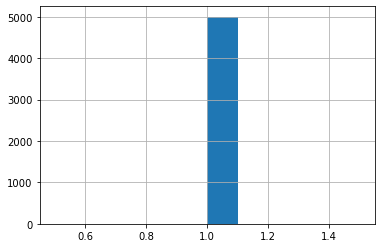

In [108]:
# Matrix should change
matrix_changes = pd.Series(matrix_changes).astype(int)
print("Matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())
matrix_changes.hist()

Error metrics
count    4000.000000
mean       56.354961
std         0.381585
min        55.027266
25%        56.098128
50%        56.356011
75%        56.612719
max        57.732140
dtype: float64


<AxesSubplot:>

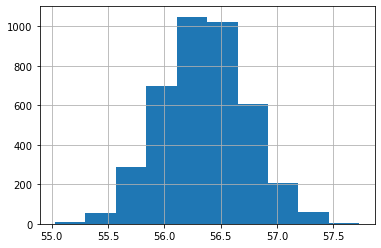

In [109]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/JE1T7Hur/31-mcsamplez-z-is-not-close-to-the-expected-target
errors = pd.Series(errors)
print("Error metrics")
print(errors.describe())
errors.hist()

<AxesSubplot:>

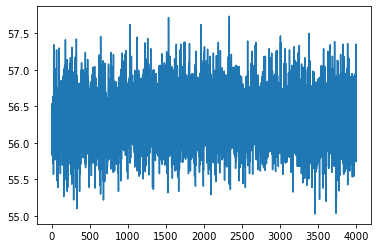

In [110]:
errors.plot()

## 2.2.1 Beta sampling

### Task:

You must implement a function that receives matrices $C_i$ and vector $\alpha$ and generates the next $B_{i+1}$.

In [91]:
def MC_sample_B(alpha, C):
    B = np.random.dirichlet(alpha + C[0,:], size=1)
    for k in range(C.shape[0]):
        B = np.concatenate((B, np.random.dirichlet(alpha + C[k,:], size=1)), axis=0)
    return B

## 2.2.2 Beta sampling tests

In [111]:
# Check that the function runs with no issues, without side effects
alpha = np.ones(V)
C_copy = test_data.C.copy()

B_sample = MC_sample_B(alpha, C_copy)

assert np.all(C_copy == test_data.C)

In [112]:
%%time
# Check that the Sampler works properly (This will take a while)
errors = []
matrix_changes = []
burn_in = 1000
print(f'The sampled B has {B_sample.size} words, while the target B has {test_data.B.size} words (diff {abs(B_sample.size-test_data.B.size)})')
for i in range(5000):
    B_sample_old = B_sample.copy()
    B_sample = MC_sample_B(alpha, C_copy)
    matrix_changes.append(~np.all(B_sample_old == B_sample))
    if i >= burn_in:
        errors.append(np.linalg.norm(B_sample - test_data.B))  # Computing error wrt the target distribution  # BUG https://trello.com/c/uEYV7fSC/32-mcsampleb-shape-mismatch

The sampled B has 72 words, while the target B has 60 words (diff 12)


ValueError: operands could not be broadcast together with shapes (6,12) (5,12) 

Matrix changes (1 = changed, 0 = same)
count    1001.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64


<AxesSubplot:>

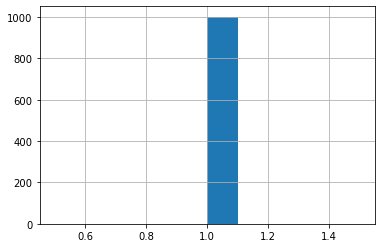

In [113]:
# Matrix should change
matrix_changes = pd.Series(matrix_changes).astype(int)
print("Matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())
matrix_changes.hist()

Error metrics
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64


/tmp/ipykernel_60224/1012157940.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  errors = pd.Series(errors)


<AxesSubplot:>

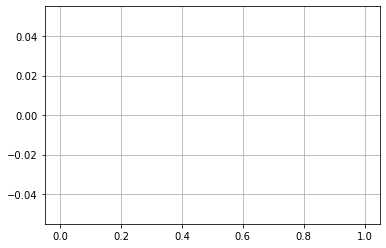

In [114]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/JE1T7Hur/31-mcsamplez-z-is-not-close-to-the-expected-target
errors = pd.Series(errors)
print("Error metrics")
print(errors.describe())
errors.hist()

<AxesSubplot:>

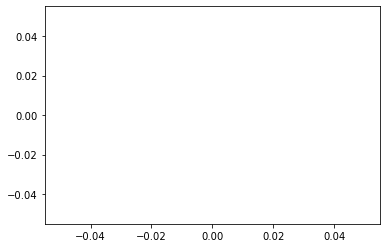

In [115]:
errors.plot()

# 2.3 Metropolis-Hastings MC Sampling

### Task:

You must implement a function that receives matrices $E_i$, $K_i$ and vector $\mu$ and generates the next $H_{i+1}$.


. $E$ matrix of $D \times k$ where $E_d$ is the $k$-dim vector of counts of sampled drawings for the $z$-th topic over all words for each document

. $K$ matrix of $k \times k$ representing the precision matrix associated to the graph $G$

. $\mu = 0$

. $H$ matrix of $D \times k$ where $H_d = \eta_d$ is the $k$-dim vector of the topic prevalences over document $d$

In [110]:
import numpy as np
import numpy.linalg

In [111]:
# np.seterr(all='raise')  # Will raise error instead of warning

In [112]:
def sampled_distribution_kernel(eta, K, E):
    k = eta.shape[0]
    eta_K_eta = -0.5 * eta.dot(K.dot(eta))
    E_eta = E.dot(eta)
    sum_eta_pow_k = np.sum(np.exp(eta)) ** k
    return np.exp(eta_K_eta + E_eta) / sum_eta_pow_k  # This np.exp raises a warning when  eta_K_eta + E_eta > 706

In [113]:
def MC_sample_H(E, Sigma, H_current=None, burn_in=100, seed=None):
    
    np.random.seed(seed)
    
    K = np.linalg.inv(Sigma)
    
    D, k = E.shape  # Number of documents, Number of topics
    
    if H_current is None:
        H_current = np.zeros((D, k))
    
    H_sampled = np.zeros((D, k))
    
    for d in range(D):  # Iterating over each document
        current_eta = H_current[d]
        E_d = E[d]
        for iteration in range(burn_in + 1):
            
            # Sampling proposed eta from multivariate normal (q "proposal density")
            proposed_eta = np.random.multivariate_normal(current_eta, Sigma)
            
            # Compute acceptance probability
            p_proposed_eta = sampled_distribution_kernel(proposed_eta, K, E_d)
            p_current_eta = sampled_distribution_kernel(current_eta, K, E_d)
            if p_proposed_eta == np.inf or p_current_eta == 0:  # Avoiding divide by 0 and other numerical creeps
                alpha = 1
            else:
                alpha = min(1, p_proposed_eta / p_current_eta)
            
            if alpha == 1 or np.random.uniform(0.0, 1.0) < alpha:
                current_eta = proposed_eta
            
        H_sampled[d] = current_eta
    
    return H_sampled

# 2.4 BDMCMC Sampling

### Task:

You must implement a function that receives matrices $W$, $Z_{i+1}$ and $H_{i+1}$ and generates the next $G_{i+1}$ and $K_{i+1}$.

In [114]:
import subprocess

# Remember to install BDgraph package version 2.62 on your R environment
# You'll need to run the following commands:
# remove.packages("BDgraph")
# install.packages("remotes")
# library(remotes)
# install_version("BDgraph", "2.62")


def MC_sample_K(G, b, shape_matrix, n_of_samples):
    # save G to csv
    np.savetxt("adj.csv", G, delimiter=",")
    # save shape_matrix to csv (OR pass them as parameters to RScript)
    np.savetxt("shape.csv", shape_matrix, delimiter=",")
    # call R script using python.subprocess
    result = subprocess.run(f"Rscript --vanilla rgwish.R {b} {n_of_samples}", shell=True) # -> HOW MANY SAMPLES ARE REQUIRED? SHOULD THIS ALSO BE VARIABLE AND THEREFORE PASSED TO R?
    if result.returncode != 0:
        raise Exception("Rscript error! Check the previous logs for more details")

    # read the results from csv (OR get the result back from R script)
    
    # Always better to open file handlers within a "with" statement (otherwise you must take care of closing the file)
    with open("gwish.csv", "r") as csv_file:  
        K = np.loadtxt(csv_file, delimiter=",")
    
    return K

In [140]:
shape_matrix

array([[797.93242237, 514.68365054, 657.73594994, 299.99365987,
        629.29651889],
       [514.68365054, 439.07410386, 471.73326408, 338.0486553 ,
        465.14098847],
       [657.73594994, 471.73326408, 664.51808301, 358.63712727,
        579.2518858 ],
       [299.99365987, 338.0486553 , 358.63712727, 368.61229719,
        328.99921418],
       [629.29651889, 465.14098847, 579.2518858 , 328.99921418,
        584.74894722]])

In [153]:
# TESTING R weird bug...
for j in range(100):
    try:
        MC_sample_K(G, j, shape_matrix, n_of_samples=1)
        print(f'No Exception with {j}')
    except:
        pass


[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 0"
[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 1"


Error in rgwish(n = n, adj = adj, b = b, D = shape) : 
  For G-Wishart distribution parameter 'b' must be more than 2
Execution halted
Error in rgwish(n = n, adj = adj, b = b, D = shape) : 
  For G-Wishart distribution parameter 'b' must be more than 2
Execution halted


[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 2"
[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 3"
[1] "[R] rgwish succesfully executed!"
No Exception with 3


Error in rgwish(n = n, adj = adj, b = b, D = shape) : 
  For G-Wishart distribution parameter 'b' must be more than 2
Execution halted


[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 4"
[1] "[R] rgwish succesfully executed!"
No Exception with 4
[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 5"
[1] "[R] rgwish succesfully executed!"
No Exception with 5
[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 6"
[1] "[R] rgwish succesfully executed!"
No Exception with 6
[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 7"
[1] "[R] rgwish succesfully executed!"
No Exception with 7
[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 8"
[1] "[R] rgwish succesfully executed!"
No Exception with 8
[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 9"
[1] "[R] rgwish succesfully executed!"
No Exception with 9
[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 10"


Error in rgwish(n = n, adj = adj, b = b, D = shape) : 
  For G-Wishart distribution parameter 'b' must be more than 2
Execution halted
Error in rgwish(n = n, adj = adj, b = b, D = shape) : 
  For G-Wishart distribution parameter 'b' must be more than 2
Execution halted


[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 11"
[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 12"


Error in rgwish(n = n, adj = adj, b = b, D = shape) : 
  For G-Wishart distribution parameter 'b' must be more than 2
Execution halted
Error in rgwish(n = n, adj = adj, b = b, D = shape) : 
  For G-Wishart distribution parameter 'b' must be more than 2
Execution halted


[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 13"
[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 14"


Error in rgwish(n = n, adj = adj, b = b, D = shape) : 
  For G-Wishart distribution parameter 'b' must be more than 2
Execution halted
Error in rgwish(n = n, adj = adj, b = b, D = shape) : 
  For G-Wishart distribution parameter 'b' must be more than 2
Execution halted


[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 15"
[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 16"


Error in rgwish(n = n, adj = adj, b = b, D = shape) : 
  For G-Wishart distribution parameter 'b' must be more than 2
Execution halted
Error in rgwish(n = n, adj = adj, b = b, D = shape) : 
  For G-Wishart distribution parameter 'b' must be more than 2
Execution halted


[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 17"
[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 18"


Error in rgwish(n = n, adj = adj, b = b, D = shape) : 
  For G-Wishart distribution parameter 'b' must be more than 2
Execution halted
Error in rgwish(n = n, adj = adj, b = b, D = shape) : 
  For G-Wishart distribution parameter 'b' must be more than 2
Execution halted


[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 19"
[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 20"
[1] "[R] rgwish succesfully executed!"
No Exception with 20
[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 21"
[1] "[R] rgwish succesfully executed!"
No Exception with 21
[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 22"
[1] "[R] rgwish succesfully executed!"
No Exception with 22
[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 23"
[1] "[R] rgwish succesfully executed!"
No Exception with 23
[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 24"
[1] "[R] rgwish succesfully executed!"
No Exception with 24
[1] "[R] rgwish will now be sampling 2 samples. The b (degrees of freedom) is set to 25"
[1] "[R] rgwish succesfully executed!"
No Exception with 25
[1] "[R] rgwish w

In [115]:
#This is a test of MC_sample_K
G = [[0,0,1,0,0],
    [0,0,0,0,0],
    [1,0,0,0,0],
    [0,0,0,0,0],
    [0,0,0,0,0]]
shape_matrix = np.eye(5, dtype=int)
MC_sample_K(G, 5, shape_matrix, n_of_samples=1)

[1] "[R] rgwish will now be sampling 1 samples. The b (degrees of freedom) is set to 5"
[1] "[R] rgwish succesfully executed!"


array([[6.66, 0.  , 0.3 , 0.  , 0.  ],
       [0.  , 6.81, 0.  , 0.  , 0.  ],
       [0.3 , 0.  , 4.99, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 3.1 , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 3.48]])

In [116]:
def MC_sample_G(W, Z, H, K, G, E, dof, shape):

    N = G.shape[0]
    delta_K = 0
    beta_K = 0

    death_rates = np.zeros((k,k))
    birth_rates = np.zeros((k,k))
    
    n = D  # It's either of the shape indices of H
    # from the paper I'm not sure yet which but looks the docs for us
    
    S = shape  # prior parameter
    b = dof  # prior parameter

    PrHK = lambda K, H:        K.size ** (n / 2) * np.exp(-0.5 * np.trace(np.matmul(np.matmul(K, H.T), H)))
    PrK_G = lambda K, G, D, b: K.size ** (b + D - 2) * np.exp(-0.5 * np.trace(np.matmul(S + np.matmul(H.T, H), K)))
    PrG = lambda gamma, E:  (gamma / (1 - gamma)) ** (E.size)
    PrKG_H = lambda K, G, H, D, b, gamma, E: PrHK(K, H) * PrK_G(K, G, D, b) * PrG(gamma, E)

    Pr_init = PrKG_H(K, G, H, D, k - 1, gamma, E)

    for i in range(N):
        for j in range(i + 1, N):
            if G[i,j]:
                G_loop = G.copy()
                G_loop[i,j] = 0
                G_loop[j,i] = 0
                #technically, we should compute K_loop here...
                Pr_loop = PrKG_H(K,G_loop,H,D,b,gamma,E)

                death_rate = Pr_loop / Pr_init

                if death_rate > 1:
                    death_rate = 1
                death_rates[i,j] = death_rate
                death_rates[j,i] = death_rate
                delta_K += death_rate

            else:
                G_loop = G.copy()
                G_loop[i,j] = 1
                G_loop[j,i] = 1
                #technically, we should compute K_loop here...
                Pr_loop = PrKG_H(K, G_loop, H, D, b, gamma, E) 

                birth_rate = Pr_loop / Pr_init

                if birth_rate > 1:
                    birth_rate = 1
                birth_rates[i,j] = birth_rate
                birth_rates[j,i] = birth_rate
                beta_K += birth_rate
    
    W = 1/(beta_K + delta_K)

    pr_death = W * death_rates
    pr_birth = W * birth_rates

    G[pr_death > 0.5] = 0
    G[pr_birth > 0.5] = 1
   
    return G

# TESTING

### MC Samplers

In [122]:
MC_sample_H(test0.E, test0.Sigma, seed=1984)

array([[19.2946997 , 18.94895738,  1.19695341,  8.2949929 , 15.98288853],
       [15.13950573, 16.2262157 ,  1.92972137,  3.04416363, 18.70501049],
       [-0.37113011,  0.29782635,  6.42274271,  3.13919577,  1.83457523],
       [11.76971001, 12.98645941,  0.42939897,  0.02712452,  9.91593295],
       [-0.1096919 , -1.11730843,  0.09967448,  0.0210885 , -1.04419454],
       [ 1.34758032,  0.13731431,  0.0306688 , -0.76673449, -1.23394873],
       [ 2.79921866,  2.61114785,  0.11921866,  0.09309914,  2.63310609],
       [ 2.04301234,  5.33734371,  1.17659208,  5.16777089,  7.42084214]])

In [123]:
shape_matrix = np.eye(k)
b = k - 1

MC_sample_G(test0.W, test0.Z, test0.H, test0.K, test0.G, test0.E, b, shape_matrix)

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]])

In [124]:
# Test for G to change (at least sometimes!)
shape_matrix = np.eye(k)
b = k - 1
G_test = MC_sample_G(test0.W, test0.Z, test0.H, test0.K, test0.G, test0.E, b, shape_matrix)
for _ in range(1000):
    G_new = MC_sample_G(test0.W, test0.Z, test0.H, test0.K, G_test, test0.E, b, shape_matrix)
    if np.all(G_new == G_test):
        print('G matrix has NOT changed!')
    else: 
        print('G matrix has changed!')
    G = G_new

G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has NOT changed!
G matrix has

In [125]:
#This is a test of MC_sample_K
G = [[0,0,1,0,0],
    [0,0,0,0,0],
    [1,0,0,0,0],
    [0,0,0,0,0],
    [0,0,0,0,0]]
shape_matrix = np.eye(5, dtype=int)
MC_sample_K(G, 5, shape_matrix, n_of_samples=1)

[1] "[R] rgwish will now be sampling 1 samples. The b (degrees of freedom) is set to 5"
[1] "[R] rgwish succesfully executed!"


array([[4.37, 0.  , 0.42, 0.  , 0.  ],
       [0.  , 4.1 , 0.  , 0.  , 0.  ],
       [0.42, 0.  , 3.48, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 4.13, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.68]])

# MAIN ALGORITHM

### Generating Data

In [126]:
simulated_data = Simulator(D, V, M, k, gamma, seed=1984)
simulated_data.generate_all_data()

Success: Sigma transformed from K
Success: Theta transformed from H
Success: W generated
Success: Z generated
Success: E transformed from Z
Success: C transformed from Z


In [127]:
# Input Data:
simulated_data.W

array([[ 0.,  3.,  1.,  2.,  3.,  6.,  0.,  3.,  2.,  3.,  2.,  3.],
       [ 0.,  2.,  0.,  2.,  3.,  9.,  1.,  6.,  3.,  5.,  0.,  5.],
       [ 0.,  3.,  1.,  7.,  1.,  4.,  4.,  8.,  2.,  7.,  1.,  9.],
       [ 0.,  2.,  0.,  4.,  5., 12.,  3.,  8.,  4.,  8.,  2.,  6.],
       [ 0.,  0.,  0.,  1.,  0.,  3.,  0.,  1.,  0.,  4.,  0.,  1.],
       [ 0.,  3.,  0.,  4.,  1.,  5.,  2.,  8.,  1.,  6.,  2.,  4.],
       [ 0.,  1.,  2.,  5.,  5.,  5.,  4.,  6.,  3.,  4.,  0.,  3.],
       [ 0.,  3.,  0.,  2.,  0.,  2.,  2.,  7.,  1.,  2.,  1.,  2.]])

# SAMPLER

In [128]:
# # Initial guesses
initial = Simulator(D, V, M, k, gamma, 2020)
initial.sample_GK()
initial.sample_B()
initial.sample_H()

Success: Sigma transformed from K
Success: Theta transformed from H


In [154]:
max_iteration = 100

# Data
W = simulated_data.W

# Initialization
Sigma = initial.Sigma
K = np.linalg.inv(Sigma)
B = initial.B
Theta = initial.Theta
G = initial.G

alpha = np.ones(V)  # Uninformative prior
b = k - 1
shape_matrix = np.eye(k)

Z = sample_Z_from_W(simulated_data.W.astype(int), k, 2020)  # Random sample of Z based on actual data

E = update_E(np.zeros((D, k)), Z)  # Transformation of Z
C = update_C(np.zeros((k, V)), Z)  # Transformation of Z


for iteration in range(max_iteration):
    
    # Step 1
    Z = MC_sample_Z(Z, W, Theta, B, E, C)
    E = update_E(E, Z)  # get E from Z
    C = update_C(C, Z)  # get C from Z ...
    
    # Step 2
    B = MC_sample_B(alpha, C)
    
    # Step 3
    H = MC_sample_H(E, Sigma)
    Theta = update_Theta(Theta, H)  # get Theta from H
    
    # Step 4
    b += D  # add D since it's the amount of etas we have
    shape_matrix += np.matmul(H.T, H)  # Add H^T H (matrix product)
    
    G_new = MC_sample_G(W, Z, H, K, G, E, b, shape_matrix)
    if np.all(G_new == G):
        print('G matrix has NOT changed!')
    G = G_new
    
    K = MC_sample_K(G, b, shape_matrix, n_of_samples=1)
    Sigma = np.linalg.inv(K)
    
    # Hope for convergence!
    wrong_edges = np.sum(G != simulated_data.G)
    error = np.linalg.norm(Sigma - simulated_data.Sigma)
    print(f"At iteration {iteration}, the wrong edges are {wrong_edges} and the error on Sigma is {error}")

Success: E transformed from Z
Success: C transformed from Z
Success: E transformed from Z
Success: C transformed from Z
Success: Theta transformed from H
G matrix has NOT changed!
[1] "[R] rgwish will now be sampling 1 samples. The b (degrees of freedom) is set to 12"


/tmp/ipykernel_44530/4061927063.py:47: RuntimeWarning: invalid value encountered in double_scalars
  birth_rate = Pr_loop / Pr_init
Error in rgwish(n = n, adj = adj, b = b, D = shape) : 
  For G-Wishart distribution parameter 'b' must be more than 2
Execution halted


Exception: Rscript error! Check the previous logs for more details

In [130]:
H.shape

(8, 5)

In [132]:
shape_matrix.shape

(5, 5)

In [133]:
b

12